In [1]:
# 1 import the moduls
import scipy.io as sio
import librosa as lb
import librosa.display
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler as st
from sklearn.decomposition import PCA

In [2]:
# 2 Function for extracting features 
def getfeatures(fdata):

    data = np.array([lb.feature.rmse(y = fdata,frame_length=1024, hop_length=512)])[0,0]
    threshold = np.ndarray.max(data[1:10])

    length = fdata.size
    data_order = data.argsort()[-5:][::-1]
    for i in range(0,4):
        start = data_order[i] * 512 - 4090
        end = data_order[i] * 512 + 4099
        if length < end + 1 :
            end = length - 1
    
        fade = fdata[end] / 2
        target = np.append(fdata[start : end],[fade])
        target = np.append(target,0)
    
        if max(np.correlate(target,target,'same')) > 10:
            break
            
         
    mfccs = lb.feature.mfcc(y=target, sr=44100, n_mfcc=14, n_fft = 8192,hop_length = 8192)    
    mfccs = mfccs[1:14]
    return mfccs, target

In [11]:
# 3 get voice imitation in
test = sio.loadmat('test_1.mat')
audio = test['audio_1']
num_row = int(np.shape(audio)[0])

In [5]:
# Get the stimuli in
stimuli_set = sio.loadmat('stimuli.mat')
stimuli = stimuli_set['audio_sti']

In [7]:
from IPython.display import Audio

# Audio

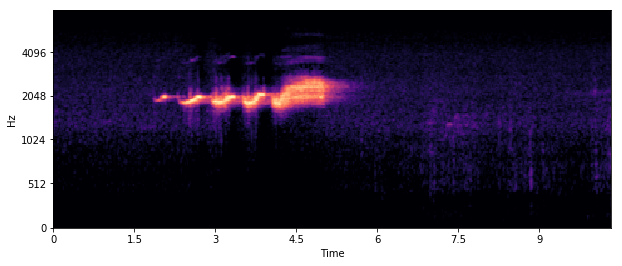

In [8]:
# STIMULI
local_sti = stimuli[14,2:-1]
end = np.nonzero(local_sti)[0][-1]
stimulus= local_sti[0:end]
S = librosa.feature.melspectrogram(stimulus)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=8000, x_axis='time')
Audio(stimulus,rate=44100)

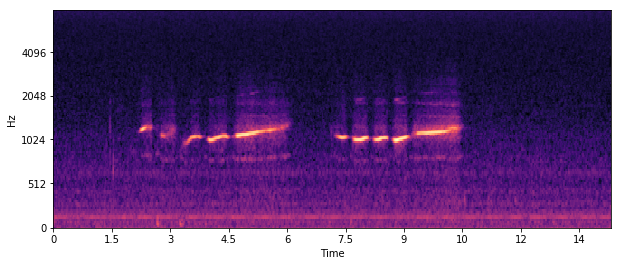

In [13]:
# WHISTLE
local = audio[114,2:-1]
stop = np.nonzero(local)[0][-1]
whistle = local[0:stop]
S = librosa.feature.melspectrogram(whistle)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=8000, x_axis='time')
Audio(whistle,rate=44100)

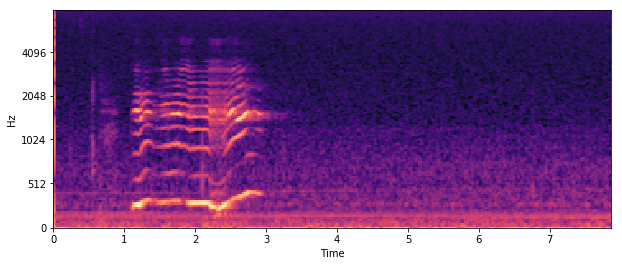

In [14]:
# SING LIKE
local = audio[213,2:-1]
stop = np.nonzero(local)[0][-1]
sing = local[0:stop]
S = librosa.feature.melspectrogram(sing)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=8000, x_axis='time')
Audio(sing,rate=44100)

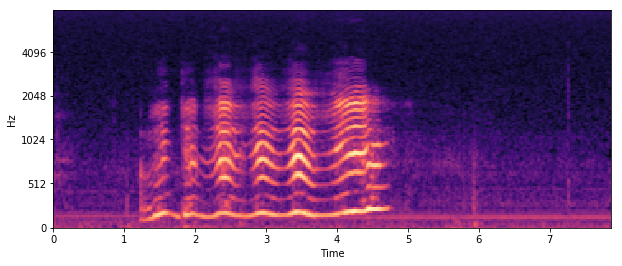

In [10]:
# NOISE LIKE
local = audio_2[113,2:-1]
stop = np.nonzero(local)[0][-1]
noise = local[0:stop]
S = librosa.feature.melspectrogram(noise)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=8000, x_axis='time')
Audio(noise,rate=44100)

# Spectral 

In [4]:
# 4 Initiate the feature vectors
subjects = []
species_all = []
mfcc_all = []

In [13]:
# 5 For each audio clip in each .mat, extract the features
for i in tqdm(range(0,num_row)):
    temp_sub = audio[i,0]
    temp_spe = audio[i,1]
    rdata = audio[i,2:-1]
    rdata_nz = np.nonzero(rdata)[0][-1]
    fdata = rdata[0:rdata_nz]
    
    mfccs,target = getfeatures(fdata)
    #if freq < 4000 and flux < 1.6:
    subjects.append(temp_sub)
    species_all.append(temp_spe)
        #flux_all.append(flux)
        #bandwidth_all.append(band)
        #freq_all.append(freq)
#    if i == 0:
#        mfcc_all = mfccs
#    else:    
    mfcc_all = np.append(mfcc_all,mfccs,1)

100%|██████████| 300/300 [00:22<00:00, 13.45it/s]


In [16]:
# Fix the problem in subject labeling
subjects = np.array(subjects)
for c in range(0,15):
    subjects[c*100:c*100 + 99] = c

In [17]:
# prepare data for clustering and visualization
data = mfcc_all
species_all = np.array(species_all)
data_flip = list(map(list, zip(*data)))

In [18]:
# Do clustering and PCA
mfcc_pca = PCA(n_components = 2)
results = mfcc_pca.fit_transform(data_flip)
print(mfcc_pca.explained_variance_ratio_) 
db = KMeans(n_clusters=2).fit(data_flip)

[0.31733741 0.20535172]


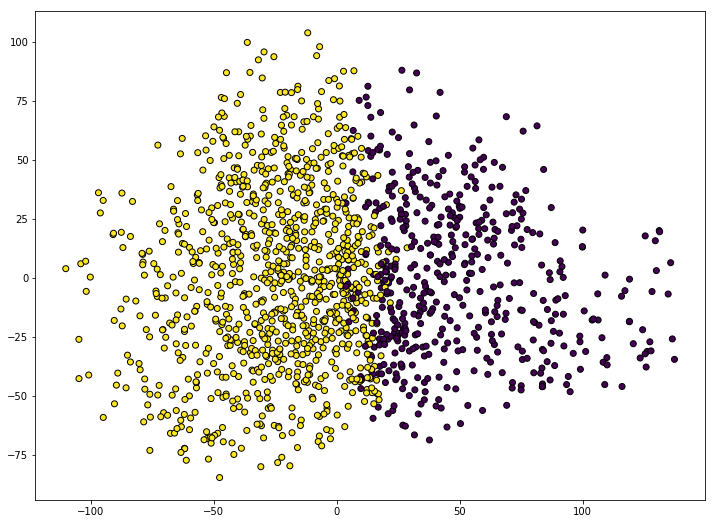

In [19]:
# Clustering results
fig = plt.figure(figsize=(12, 9))
plt.scatter(results[:,0], results[:,1],c=db.labels_.astype(np.float), edgecolor='k')
    
plt.show() 

In [72]:
# Calculate the numbers of whistling between species & subjects
sub = []
for i in range(15):
    ind_wts = np.where(db.labels_ == 0)[0]
    sub.append(sum((subjects[s] == i) for s in ind_wts))
sub = np.array(sub)

spe = []
for i in range(10):
    ind_wts = np.where(db.labels_ == 0)[0]
    spe.append(sum((species_all[s] == i) for s in ind_wts))
spe = np.array(spe)  

print(sub)
#spe = np.sort(spe)
#non_spe = 150 - spe
#sub = np.sort(sub)
#non_sub = 100 - sub

[ 1 68 30 43 63  4  1 45 24 16 82 23 54  4 42]


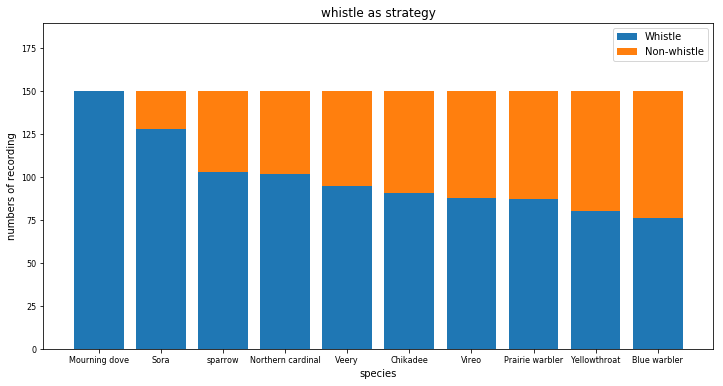

In [57]:
# Plot whistle results between species
fig = plt.figure(figsize=(12, 6))
species1 = plt.bar(range(10),non_spe)
species2 = plt.bar(range(10),spe,bottom=non_spe)

plt.ylabel('numbers of recording')

plt.title('whistle as strategy')
plt.xlabel('species')
plt.xticks(np.arange(10),('Mourning dove','Sora','sparrow','Northern cardinal','Veery','Chikadee','Vireo','Prairie warbler','Yellowthroat','Blue warbler'))
plt.tick_params(axis = 'both', labelsize = 8)
plt.legend((species1[0], species2[0]), ('Whistle', 'Non-whistle'))
plt.ylim(0,190)

plt.show()

In [15]:
dove_clip = stimuli[36,2:-1]
end = np.nonzero(dove_clip)[0][-1]
dove= dove_clip[0:end]
Audio(dove,rate=44100)

In [16]:
warbler_clip = stimuli[13,2:-1]
end = np.nonzero(warbler_clip)[0][-1]
warbler= warbler_clip[0:end]
Audio(warbler,rate=44100)

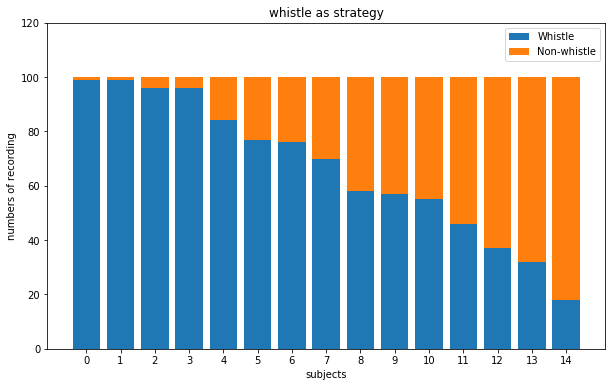

In [63]:
# Plot whistle results between subjects
fig = plt.figure(figsize=(10, 6))
subjects1 = plt.bar(range(15),non_sub)
subjects2 = plt.bar(range(15),sub,bottom=non_sub)

plt.ylabel('numbers of recording')
plt.xlabel('subjects')
plt.title('whistle as strategy')
plt.xticks(np.arange(15))
plt.legend((subjects1[0], subjects2[0]), ('Whistle', 'Non-whistle'))
plt.ylim(0,120)

plt.show()

# Temporal 

In [185]:
def VAD(x,Tp,Ta):
    locs = scipy.signal.find_peaks(x,height = Tp)[0]
    y = (x > Ta) * 1
    act = np.diff(y)
    u = np.where(act == 1)[0]
    d = np.where(act == -1)[0]
    signal_length = len(x)
    
    if d[0] < u[0]:
        u = np.insert(u,0,0)
        
    if d[-1] < u[-1]:
        d = np.append(d,signal_length-1)
        
    starts = []
    ends = []
    
    activity = np.zeros(signal_length,)
    
    for candidate_up, candidate_down in zip(u, d):
        candidate_segment = range(candidate_up, candidate_down)
        peaks_in_segment = [x in candidate_segment for x in locs]
        is_valid_candidate = np.any(peaks_in_segment)
        if is_valid_candidate:
            starts.append(candidate_up)
            ends.append(candidate_down)
            activity[candidate_segment] = 1.0
            
    
    starts = np.array(starts)
    ends = np.array(ends)
    return activity, starts, ends

(0, 1)

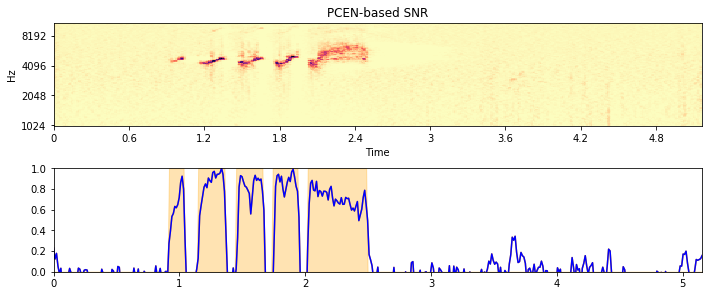

In [195]:
import scipy


sr = 44100
n_mels = 128
fmin = 1000
fmax = 11025
test = stimulus 

melspec = librosa.feature.melspectrogram(test, sr=sr, 
    fmin=fmin, fmax=fmax, n_mels=n_mels)
logmelspec = librosa.power_to_db(melspec)
pcen = librosa.core.pcen(melspec, sr=sr,
    gain=0.8, bias=10, power=0.25, time_constant=0.06, eps=1e-06)

pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
pcen_snr = pcen_snr / np.max(pcen_snr)
median_pcen_snr = signal.medfilt(pcen_snr, kernel_size=1)

activity, start, end = VAD(median_pcen_snr,0.5,0.3)
activity_count = len(start)

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)

librosa.display.specshow(pcen, sr=sr,
    fmin=fmin, fmax=fmax,
    x_axis='time', y_axis='mel', cmap='magma_r')
plt.title('PCEN-based SNR')
plt.tight_layout()
plt.subplot(3, 1, 2)

times = np.linspace(0, len(test)/sr, num=logmelspec.shape[1])
plt.plot(times, pcen_snr, color="orange")
plt.plot(times, median_pcen_snr, color="blue")
plt.fill_between(times, 0*np.ones(len(times),),
    activity, color="orange", alpha=0.3)
plt.xlim(times[0], times[-1])
plt.ylim(0, 1)

In [ ]:
def detect_activity(y, sr,
        n_mels=128, fmin=1000, fmax=11025, hop_length=512
        gain=0.8, bias=10, power=0.25, time_constant=0.06, eps=1e-06,
        kernel_size=1,
        peak_threshold=0.5, activity_threshold=0.3):
    # 1. compute mel-frequency spectrogram
    # (call librosa melspec)
    
    
    # 2. compute PCEN
    # (call librosa PCEN)

    # 3. compute PCEN-SNR detection function
    # (copy-paste from Vincent's notebook)

    # 4. find peaks
    # (copy-paste from Natalie's notebooks)

    # 5. extract active segments
    # (copy-paste from Natalie's notebooks)


    # 6. convert indices to seconds
    # (just multiply by sr/hop_length)

    return start_times, end_times
